In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomContrast

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# include only those gestures
CONDITIONS = ['like', 'stop']

# Path to data
DATA_PATH = "/home/raphi/Documents/Universität/Master/SS 23/ITT/Exercises/Exercise-06"

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

2023-06-10 23:21:15.769337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 23:21:15.833718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-10 23:21:15.834484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 23:21:17.499994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Define helper functions

In [2]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{DATA_PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [3]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## Load images and annotations

In [4]:
images = []
labels = []
label_names = []

for condition in CONDITIONS:
    for filename in os.listdir(f"{DATA_PATH}/{condition}"):

        UID = filename.split('.')[0]
        img = cv2.imread(f'{DATA_PATH}/{condition}/{filename}')
        
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        for i, bbox in enumerate(annotation['bboxes']):
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

## Split data set into train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

## Transform data sets into a format compatible with neural network

In [6]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


## Model setup

The kernel size of the convolution layer was changed as described further below

In [7]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(1, 1), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (10, 10), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## Training the model

In [8]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 7s 76ms/step - loss: 1.0177 - accuracy: 0.4395 - val_loss: 0.9299 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 5s 74ms/step - loss: 0.7326 - accuracy: 0.6992 - val_loss: 0.6772 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 5s 72ms/step - loss: 0.5261 - accuracy: 0.8184 - val_loss: 0.6137 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 5s 74ms/step - loss: 0.3879 - accuracy: 0.8711 - val_loss: 0.3687 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 5s 72ms/step - loss: 0.3212 - accuracy: 0.8730 - val_loss: 0.5145 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 5s 75ms/step - loss: 0.2467 - accuracy: 0.9180 - val_loss: 0.3154 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 5s 73ms/step - loss: 0.1

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (8, 64, 64, 3)            0         
                                                                 
 random_contrast (RandomCont  (8, 64, 64, 3)           0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (8, 64, 64, 64)           256       
                                                                 
 max_pooling2d (MaxPooling2D  (8, 16, 16, 64)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (8, 6, 6, 32)            0

## Plot accuracy and loss of the training process

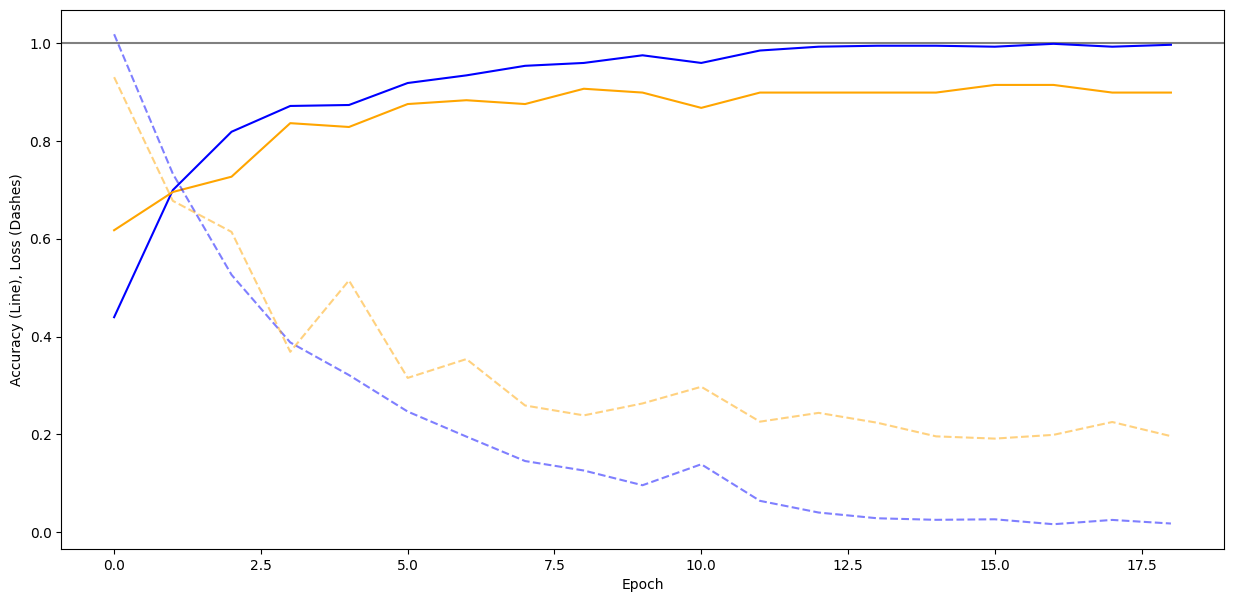

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## visualize classification results with a confusion matrix

4/4 [==============================] - 0s 50ms/step
before [[5.79263666e-04 5.22776914e-04 9.98897910e-01]
 [3.17706872e-05 9.99959409e-01 8.69342875e-06]
 [1.18013190e-08 9.99999940e-01 2.85803770e-10]
 [9.99885261e-01 9.94804141e-05 1.51004997e-05]
 [9.99562562e-01 3.06453847e-04 1.30963279e-04]
 [1.66457570e-09 9.99999940e-01 9.26215181e-12]
 [2.18893019e-05 9.99977767e-01 2.30953148e-07]
 [5.52353170e-03 9.83948529e-01 1.05278753e-02]
 [9.16314580e-10 9.99999940e-01 4.93048831e-11]
 [8.64935191e-06 9.99990046e-01 1.19947981e-06]
 [6.19314960e-04 4.68271668e-04 9.98912394e-01]
 [9.41636145e-01 1.86321568e-02 3.97317000e-02]
 [9.99990165e-01 2.80457084e-06 6.90526349e-06]
 [9.99517620e-01 4.76897723e-04 5.52545043e-06]
 [7.84338266e-03 9.92152929e-01 3.61721959e-06]
 [9.90750194e-01 1.44466525e-04 9.10525676e-03]
 [2.66897283e-03 9.99077708e-02 8.97423208e-01]
 [8.50290974e-07 3.41238120e-07 9.99998748e-01]
 [1.58394209e-06 9.99996960e-01 1.40216855e-06]
 [1.03493050e-01 6.00520347e-

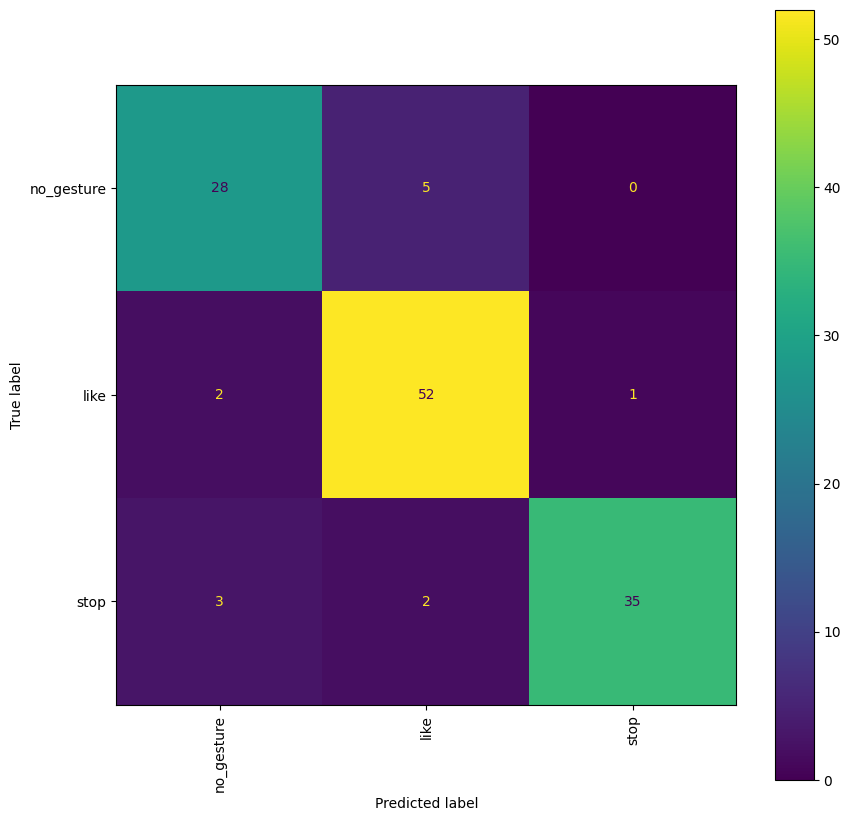

In [11]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# Influence of kernel size on model performance

## Parameters

To gather insight on the effect of kernel size on the model performance the following parameters were tested:

- **All low**:
    Every convolution layer applied a kernel size of **(1/1)**
- **All high**:
    Every convolution layer applied a (comparatively) high kernel size of **(10/10)**
- **All mid**:
    Every convolution layer applied a kernel size of **(5/5)**
- **High to low**:
    The first convolution layer applied a **(10/10)** kernel, the second one **(5/5)**, the last one **(1/1)**
- **Low to high**:
    The first convolution layer applied a **(1/1)** kernel, the second one **(5/5)**, the last one **(10/10)**

Everything else remained unchanged

## Method

For each parameter 10 training sessions were carried out with the script above and every session was logged to the raw_data.csv file.

## Assumptions

1. Effects on computing time: Higher kernel sizes might lead to higher computing times, as the complexity of operations increases
2. As convolution layers are used to extract features from images, small sizes might not be able to identify features, whereas larger kernels could make to rough of an assumption. This could mean, that medium kernel sizes lead to the highest performance

In [1]:
import pandas as pd

In [4]:
df = pd.read_csv("./raw_data.csv")
df = df.drop(columns="Attempt")
grouped = df.groupby("kernel_size").mean()

In [5]:
grouped

,Epochs,Time / Epoch (s),Total Time (s),Time / step (ms),Loss,Accuracy,Val_loss,Val_accuracy
kernel_size,,,,,,,,
(1/1),26.1,2.4,63.3,37.3,0.27112,0.90272,0.43597,0.84376
(10/10),27.6,12.5,343.8,194.3,0.11125,0.96543,0.23352,0.93436
(5/5),15.0,5.3,81.1,81.6,0.04387,0.98670,0.11169,0.96877
HIGH-LOW,17.4,8.4,147.0,131.7,0.11075,0.96463,0.18497,0.93828
LOW-HIGH,14.0,5.0,70.0,76.2,0.05300,0.98594,0.21900,0.91640


## Findings

- Higher kernel sizes lead to a higher overall training time
- Accuracy doesn't increase with kernel size
- The highest accuracy was reached when applying a constant medium kernel on all convolution layers
- Higher kernel sizes lead to a high increase of trainable parameters (as seen in ./model_summaries)